In [1]:
# Import functions and libraries
from __future__ import division
%pylab
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pyaudio
import Queue
import threading,time
import sys
from numpy import *
from scipy import *
import scipy.signal as signal
from rtlsdr import RtlSdr
from numpy.fft import *
from scipy import signal

import serial
%matplotlib inline


Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Plot an image of the spectrogram y, with the axis labeled with time tl,
# and frequency fl
#
# t_range -- time axis label, nt samples
# f_range -- frequency axis label, nf samples
# y -- spectrogram, nf by nt array
# dbf -- Dynamic range of the spect

def sg_plot( t_range, f_range, y, dbf = 60) :
    eps = 1e-3
    
    # find maximum
    y_max = abs(y).max()
    
    # compute 20*log magnitude, scaled to the max
    y_log = 20.0 * np.log10( abs( y ) / y_max + eps )
    
    fig=figure(figsize=(15,6))
    
    plt.imshow( np.flipud( 64.0*(y_log + dbf)/dbf ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Phase')
    plt.tight_layout()
    
def phase_plot(t_range, f_range, y, dbf = 60):
    eps = 1e-3
    
#     # find maximum
#     y_max = abs(y).max()
    
#     # compute 20*log magnitude, scaled to the max
#     y_log = 20.0 * np.log10( abs( y ) / y_max + eps )

    y_phase = np.angle(y)
    
    fig=figure(figsize=(15,6))
    # 64.0*(y_phase + dbf)/dbf 
    plt.imshow( np.flipud(y_phase ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Frequency, Hz')
    plt.tight_layout()


def myspectrogram_hann_ovlp(x, m, fs, fc,dbf = 60):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a rectangular window %
    
    
    isreal_bool = isreal(x).all()
    
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m
    x = append(x,zeros(-lx+nt*m))
    x = x.reshape((m/2,nt*2), order='F')
    x = concatenate((x,x),axis=0)
    x = x.reshape((m*nt*2,1),order='F')
    x = x[r_[m//2:len(x),ones(m//2)*(len(x)-1)].astype(int)].reshape((m,nt*2),order='F')
    
    
    xmw = x * hanning(m)[:,None];
    
    
    # frequency index
    t_range = [0.0, lx / fs]
    
    if isreal_bool:
        f_range = [ fc, fs / 2.0 + fc]
        xmf = np.fft.fft(xmw,len(xmw),axis=0)
        sg_plot(t_range, f_range, xmf[0:m/2,:],dbf=dbf)
        print 1
    else:
        f_range = [-fs / 2.0 + fc, fs / 2.0 + fc]
        xmf = np.fft.fftshift( np.fft.fft( xmw ,len(xmw),axis=0), axes=0 )
        sg_plot(t_range, f_range, xmf,dbf = dbf)
    
    return t_range, f_range, xmf

def myspectrogram_phase_hann_ovlp(x, m, fs, fc,dbf = 60):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a rectangular window %
    
    
    isreal_bool = isreal(x).all()
    
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m
    x = append(x,zeros(-lx+nt*m))
    x = x.reshape((m/2,nt*2), order='F')
    x = concatenate((x,x),axis=0)
    x = x.reshape((m*nt*2,1),order='F')
    x = x[r_[m//2:len(x),ones(m//2)*(len(x)-1)].astype(int)].reshape((m,nt*2),order='F')
    
    
    xmw = x * hanning(m)[:,None];
    
    
    # frequency index
    t_range = [0.0, lx / fs]
    
    if isreal_bool:
        f_range = [ fc, fs / 2.0 + fc]
        xmf = np.fft.fft(xmw,len(xmw),axis=0)
        phase_plot(t_range, f_range, xmf[0:m/2,:],dbf=dbf)
        print 1
    else:
        f_range = [-fs / 2.0 + fc, fs / 2.0 + fc]
        xmf = np.fft.fftshift( np.fft.fft( xmw ,len(xmw),axis=0), axes=0 )
        phase_plot(t_range, f_range, xmf,dbf = dbf)
    
    return t_range, f_range, xmf


def play_audio( Q, p, fs , dev, ser="", keydelay=0.200):
    # play_audio plays audio with sampling rate = fs
    # Q - A queue object from which to play
    # p   - pyAudio object
    # fs  - sampling rate
    # dev - device number
    # ser - pyserial device to key the radio
    # keydelay - delay after keying the radio
    
    # Example:
    # fs = 44100
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # Q = Queue.queue()
    # Q.put(data)
    # Q.put("EOT") # when function gets EOT it will quit
    # play_audio( Q, p, fs,1 ) # play audio
    # p.terminate() # terminate pyAudio
    
    # open output stream
    ostream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),output=True,output_device_index=dev)
    # play audio
    while (1):
        data = Q.get()
        if data=="EOT"  :
            break
        elif (data=="KEYOFF"  and ser!=""):
            time.sleep(keydelay)
            ser.setDTR(0)
            #print("keyoff\n")
        elif (data=="KEYON" and ser!=""):
            ser.setDTR(1)  # key PTT
            #print("keyon\n")
            time.sleep(keydelay) # wait 200ms (default) to let the power amp to ramp up
            
        else:
            try:
                ostream.write( data.astype(np.float32).tostring() )
            except:
                print("Exception")
                break
            
def record_audio( queue, p, fs ,dev,chunk=1024):
    # record_audio records audio with sampling rate = fs
    # queue - output data queue
    # p     - pyAudio object
    # fs    - sampling rate
    # dev   - device number 
    # chunk - chunks of samples at a time default 1024
    #
    # Example:
    # fs = 44100
    # Q = Queue.queue()
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # record_audio( Q, p, fs, 1) # 
    # p.terminate() # terminate pyAudio
    
   
    istream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),input=True,input_device_index=dev,frames_per_buffer=chunk)

    # record audio in chunks and append to frames
    frames = [];
    while (1):
        try:  # when the pyaudio object is distroyed stops
            data_str = istream.read(chunk) # read a chunk of data
        except:
            break
        data_flt = np.fromstring( data_str, 'float32' ) # convert string to float
        queue.put( data_flt ) # append to list



In [3]:
# Your code here:
def genChirpPulse(Npulse, f0, f1, fs):
    #     Function generates an analytic function of a chirp pulse
    #     Inputs:
    #             Npulse - pulse length in samples
    #             f0     - starting frequency of chirp
    #             f1     - end frequency of chirp
    #             fs     - sampling frequency
    
    # generate time index
    sec_dur = Npulse * (1/fs)
    t = np.arange(0,sec_dur + 1/fs,1/fs)

    # generate f_of_t
    slope = (f1 - f0)/sec_dur
    f_of_t = slope*t + f0

    # generate phi_of_t
    phi_of_t = 2*math.pi*np.cumsum(f_of_t) * (1/fs)

    # generate chirp signal
    s_chirp = (0.5 * np.ones(len(t))) * map(math.sin,phi_of_t) 
    
    return s_chirp

In [4]:
def text2Morse(text,fc,fs,dt):
    CODE = {'A': '.-',     'B': '-...',   'C': '-.-.', 
        'D': '-..',    'E': '.',      'F': '..-.',
        'G': '--.',    'H': '....',   'I': '..',
        'J': '.---',   'K': '-.-',    'L': '.-..',
        'M': '--',     'N': '-.',     'O': '---',
        'P': '.--.',   'Q': '--.-',   'R': '.-.',
     	'S': '...',    'T': '-',      'U': '..-',
        'V': '...-',   'W': '.--',    'X': '-..-',
        'Y': '-.--',   'Z': '--..',
        
        '0': '-----',  '1': '.----',  '2': '..---',
        '3': '...--',  '4': '....-',  '5': '.....',
        '6': '-....',  '7': '--...',  '8': '---..',
        '9': '----.',

        ' ': ' ', "'": '.----.', '(': '-.--.-',  ')': '-.--.-',
        ',': '--..--', '-': '-....-', '.': '.-.-.-',
        '/': '-..-.',   ':': '---...', ';': '-.-.-.',
        '?': '..--..', '_': '..--.-'
        }
    
    Ndot= 1.0*fs*dt
    Ndah = 3*Ndot
    
    sdot = sin(2*pi*fc*r_[0.0:Ndot]/fs)
    sdah = sin(2*pi*fc*r_[0.0:Ndah]/fs)
    
    # convert to dit dah
    mrs = ""
    for char in text:
        mrs = mrs + CODE[char.upper()] + "*"
    
    sig = zeros(1)
    for char in mrs:
        if char == " ":
            sig = concatenate((sig,zeros(Ndot*7)))
        if char == "*":
            sig = concatenate((sig,zeros(Ndot*3)))
        if char == ".":
            sig = concatenate((sig,sdot,zeros(Ndot)))
        if char == "-":
            sig = concatenate((sig,sdah,zeros(Ndot)))
    return sig            

In [5]:
def printDevNumbers(p):
    N = p.get_device_count()
    for n in range(0,N):
        name = p.get_device_info_by_index(n).get('name')
        print n, name

In [6]:
p = pyaudio.PyAudio()
printDevNumbers(p)
p.terminate()

0 Built-in Microph
1 Built-in Output


In [7]:
dusb_in = 2
dusb_out = 2
din = 0
dout = 1

In [8]:
if sys.platform == 'darwin':  # Mac
    s = serial.Serial(port='/dev/tty.SLAB_USBtoUART')
#     s = serial.Serial(port='/dev/cu.SLAB_USBtoUART')
else:                         #windows
    s = serial.Serial(port='COM1') ##### CHANGE !!!!!!
s.setDTR(0)

In [37]:
# ?RtlSdr

#For callibration

In [73]:
# Record from SDRs
%run acquire.py

SDR 0: Acquired 0 samples.
SDR 1: Acquired 0 samples.
SDR 0: Acquired 1024000 samples.
SDR 1: Acquired 1024000 samples.
SDR 0: Closed as fuck.
SDR 1: Closed as fuck.
Printing Queue 0
	- Queue size: 1
1
Done
Printing Queue 1
	- Queue size: 1
1
Done


In [74]:
samples = np.load('LO_circle_right_01.npy') #can overwrite: 05 07 #06 is Miki's tone #LO_test_10_tone_miki.npy 
#23_radio has a beautiful cross correlation

y0 = samples[0]
y1 = samples[1]
print len(samples)
# y2 = samples[2]

2


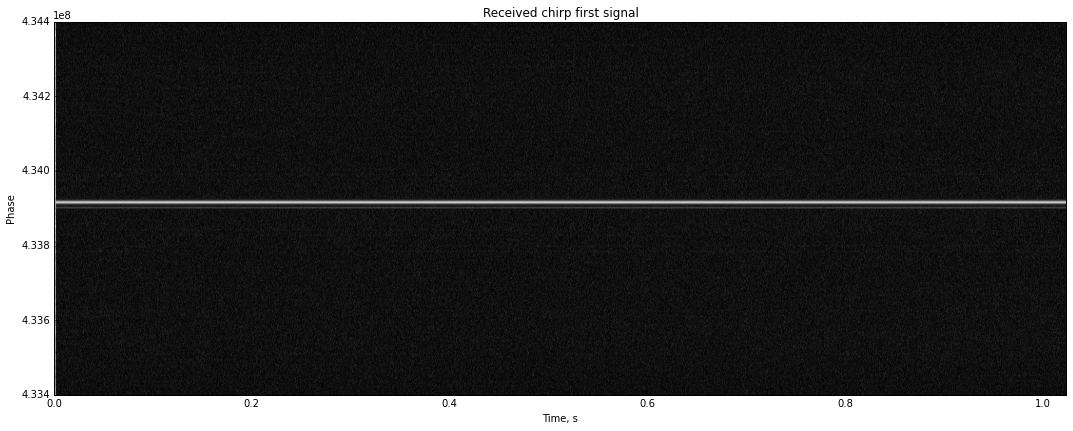

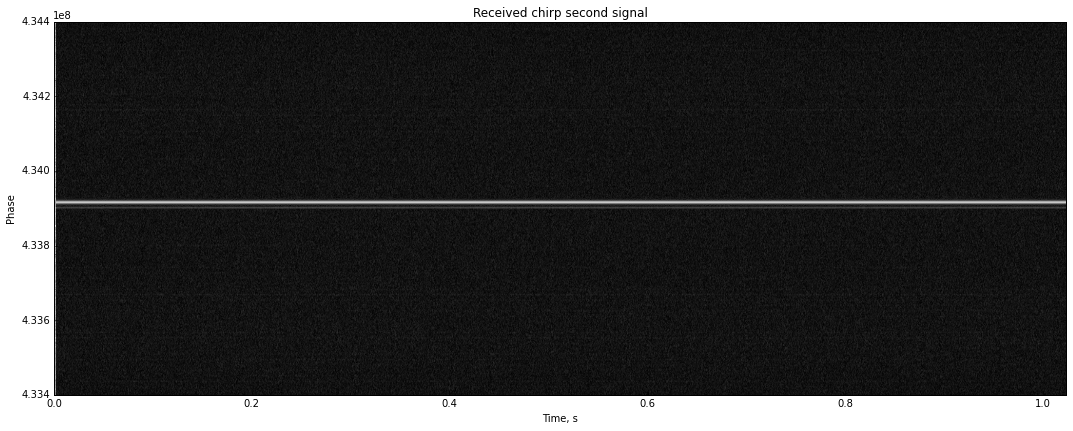

In [75]:
m = 512
fs = 1e6 #1e6 #3.2e6 #240000
fc = 433.9e6 #145.230e6 #145.530e6 #315e6 #144.25e6 #443.61e6

myspectrogram_hann_ovlp(y0, m, fs, fc, dbf = 60)
plt.title('Received chirp first signal')
myspectrogram_hann_ovlp(y1, m, fs, fc, dbf = 60)
plt.title('Received chirp second signal')
# myspectrogram_hann_ovlp(y2, m, fs, fc, dbf = 60)
# plt.title('Received chirp second signal')

527175
527175
527175


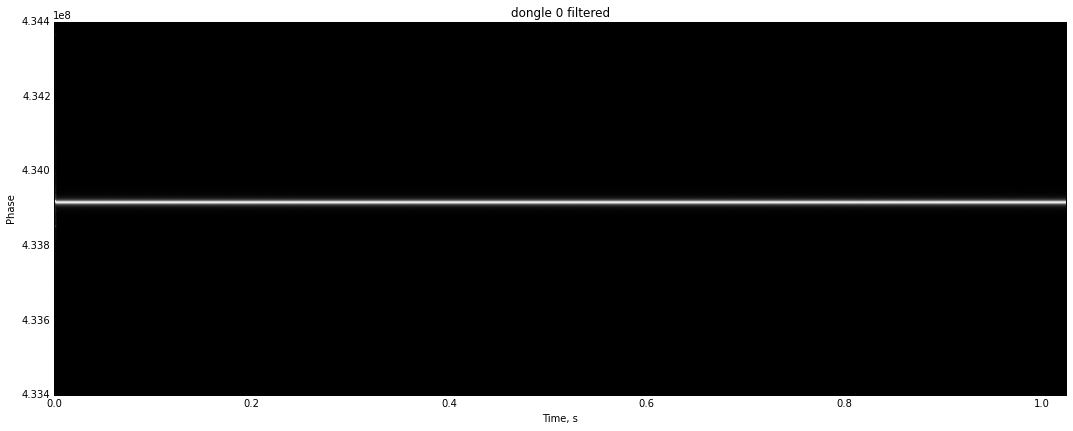

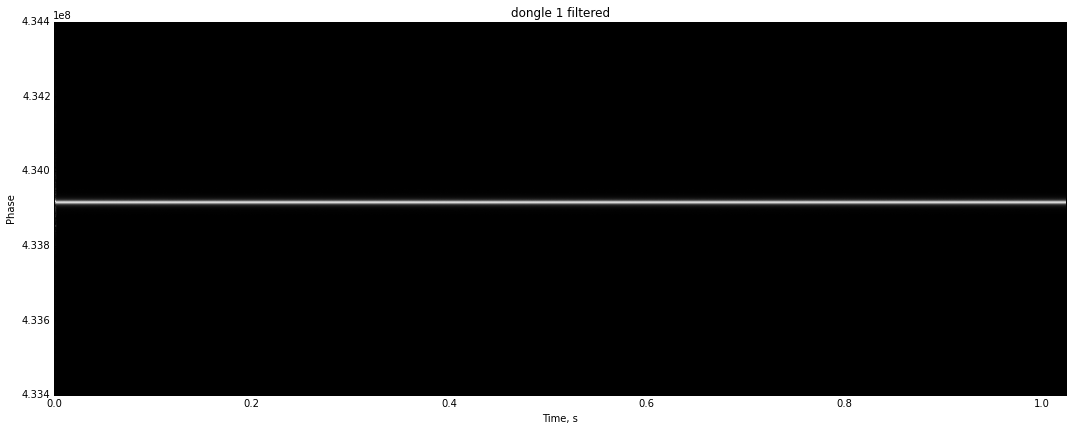

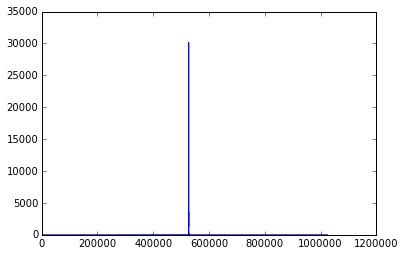

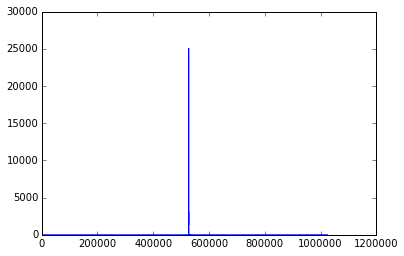

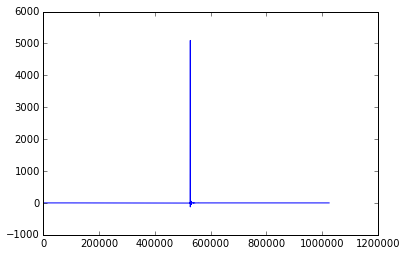

In [76]:
taps = 685
# taps = 700

mod_val = -0.016e6 #0.04e6 #-0.3e6
h = sp.signal.firwin(taps, 1/fs)
t = np.arange(taps) * (1/fs)
mod = exp(-1j*2*pi*mod_val*t)
h = h*mod

filt_y0 = signal.fftconvolve(y0, h)
filt_y1 = signal.fftconvolve(y1, h)

myspectrogram_hann_ovlp(filt_y0, m, fs, fc,dbf = 63)
title('dongle 0 filtered')
myspectrogram_hann_ovlp(filt_y1, m, fs, fc,dbf = 63)
title('dongle 1 filtered')

freq0 = np.fft.fftshift(np.fft.fft(filt_y0)) 
freq1 = np.fft.fftshift(np.fft.fft(filt_y1)) 
figure()
plt.plot(abs(freq0))
figure()
plt.plot(abs(freq1))

print abs(freq0).tolist().index(max(abs(freq0)))
print abs(freq1).tolist().index(max(abs(freq1)))
print (abs(freq0)-abs(freq1)).tolist().index(max(abs(freq0)-abs(freq1)))

figure()
plt.plot((abs(freq0)-abs(freq1))) #[225000:275000]


200
-151


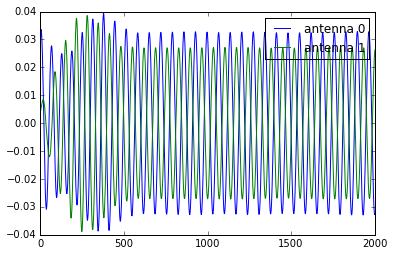

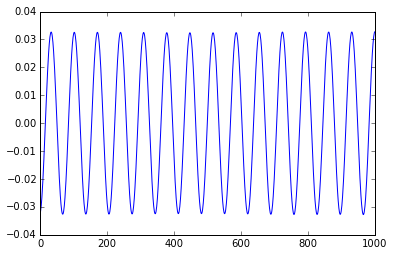

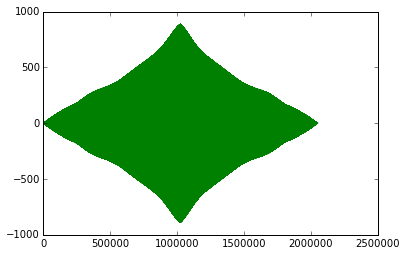

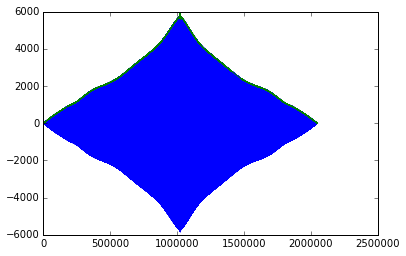

In [77]:
# Calculating USB delay

figure()
plt.plot(filt_y0[2000:4000], label='antenna 0')
plt.plot(filt_y1[2000:4000], label='antenna 1')
plt.legend()

figure()
plt.plot(filt_y0[4000:5000], label='antenna 0')

# figure()
# plt.plot(filt_y0, label='antenna 0')
# plt.plot(filt_y1, label='antenna 1')
# plt.legend()


filt_xcorr_abs = abs(signal.fftconvolve(filt_y0, np.conjugate(filt_y1)[::-1]))
filt_xcorr = signal.fftconvolve(filt_y0, np.conjugate(filt_y1)[::-1])
filt_trun_xcorr_abs = abs(signal.fftconvolve(filt_y0[int(len(h)/2)-1:-(int(len(h)/2))], (np.conjugate(filt_y1)[::-1])[int(len(h)/2)-1:-(int(len(h)/2))]))
filt_trun_xcorr = signal.fftconvolve(filt_y0[int(len(h)/2)-1:-(int(len(h)/2))], (np.conjugate(filt_y1)[::-1])[int(len(h)/2)-1:-(int(len(h)/2))])

figure()
plt.plot(filt_xcorr_abs)
plt.plot(filt_xcorr)

# figure()
# plt.plot(filt_trun_xcorr_abs)
# plt.plot(filt_trun_xcorr)

orig_xcorr = signal.fftconvolve(y0, np.conjugate(y1)[::-1])
orig_xcorr_abs = abs(signal.fftconvolve(y0, np.conjugate(y1)[::-1]))

figure()
plt.plot(orig_xcorr)
plt.plot(orig_xcorr_abs)

# print np.argmax(filt_xcorr)-len(y0) + 1
print np.argmax(orig_xcorr_abs)-len(y0) + 1
print np.argmax(filt_xcorr_abs)-len(y0) + 1
# print np.argmax(filt_trun_xcorr_abs)-len(y0) + 1
# print np.argmax(filt_trun_xcorr)-len(y0) + 1
# print np.argmax(orig_xcorr)-len(y0) + 1

delay = np.argmax(orig_xcorr_abs)-len(y0) + 1
# if delay < 0:
#     delay = -delay

filt_delay = np.argmax(filt_xcorr_abs)-len(y0) + 1
# if filt_delay < 0:
#     filt_delay = - filt_delay

2.72349221636
2.21416991787


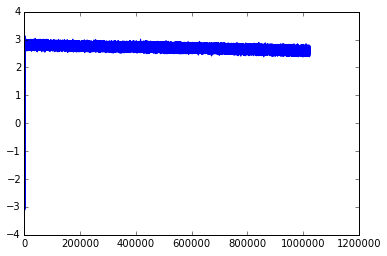

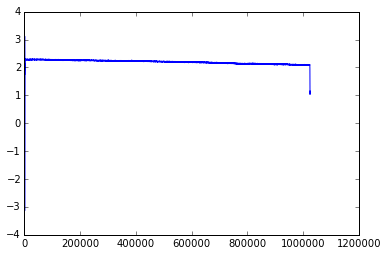

In [78]:
phase_diff_orig = np.angle(y0[delay:] * np.conjugate(y1[:-delay]))
# phase_diff_orig = np.angle(y0[:delay] * np.conjugate(y1[-delay:])) #negative delay

figure()
plt.plot(phase_diff_orig)

print np.mean(phase_diff_orig[:800000])

# phase_diff_filt = np.angle(filt_y0[filt_delay:] * np.conjugate(filt_y1[:-filt_delay]))
phase_diff_filt = np.angle(filt_y0[:filt_delay] * np.conjugate(filt_y1[-filt_delay:])) # negative delay

figure()
plt.plot(phase_diff_filt)

print np.mean(phase_diff_filt[:800000])

# phase_offset = np.mean(phase_diff_orig[:100000])

phase_offset = np.mean(phase_diff_filt[:800000])


trial 1
2.48973285577 - orig (works, less ideal)
1.21698885726 - filtered (works)
trial 2
0.239412471256 - orig
0.872768045459 - filtered (works)
trial 3 
-0.379180135882 - orig (works)
-1.48783830282 - filtered (NOT CONSTANT, rekt)

In [79]:
print (1.21698885726+0.872768045459)/2
phase_offset_test = (1.21698885726+0.872768045459)/2

1.04487845136


In [80]:
phase_sweep = exp(-1j*np.arange(-0.5,0.5,1/20) * 2 * pi)
all_summed = []
for phase in phase_sweep:
#     summed = filt_y0[filt_delay:] + phase * filt_y1[:-filt_delay]
    summed = filt_y0[:filt_delay] + phase * filt_y1[-filt_delay:] #negative delay
#     summed = y0[:delay] + phase * y1[-delay:] # negative delay
#     summed = y0[delay:] + phase * y1[:-delay]
    all_summed.append(np.dot(summed, np.conjugate(summed)))
    
ind = np.argmax(np.array(all_summed))

# print all_summed
print np.argmax(all_summed)
print np.angle(phase_sweep[ind]) - phase_offset
print np.angle(phase_sweep[ind]) - phase_offset_test

3
-0.015055060358
1.15423640615


25
-1.1780972451


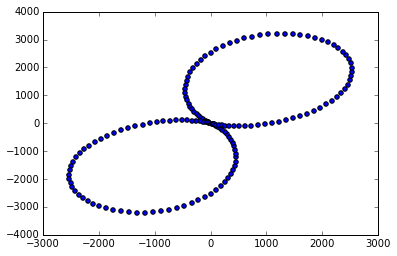

In [82]:
# sweep_angle(y0[delay:], y1[:-delay], phase_offset)
# sweep_angle(y0[:delay], y1[-delay:], phase_offset) #negative delay
# sweep_angle(filt_y0[filt_delay:], filt_y1[:-filt_delay], phase_offset_test)
sweep_angle(filt_y0[:filt_delay], filt_y1[-filt_delay:], phase_offset_test) #negative delay

In [17]:
def sweep_angle(y0, y1, offset, step_size=1/80):
    phase_sweep = np.arange(-0.5,0.5,step_size) * 2 * pi
    all_summed = []
    for phase in phase_sweep:
#         summed = y0 + np.exp(-1j*phase + offset) * y1
        summed = y0 + np.exp(-1j*(phase - offset)) * y1
        all_summed.append(np.dot(summed, np.conj(summed)))
    
    ind = np.argmax(np.array(all_summed))
    
    x = []
    y = []
    for phase, energy in zip(phase_sweep, all_summed):
        x.append(energy*np.cos(phase/2 + pi/2))
        y.append(energy*np.sin(phase/2 + pi/2))
        
        x.append(-energy*np.cos(phase/2 + pi/2))
        y.append(-energy*np.sin(phase/2 + pi/2))
        
    plt.scatter(x, y)
    
    print np.argmax(all_summed)
    print phase_sweep[ind]
